# Summary:
This notebook will cover **Latent Semantic Analysis (LSA)**. **Truncated singular value decomposition (SVD)** is applied to count matrix obtained from **CountVectorizer** or **TfidfVectorizer** to perform linear dimensionality reduction. Machine learning models **LogisticRegression**, **RandomForestClassifier** and **XGBClassifier** will then be applied to the matrix with reduced dimension.

# Table of contents
<br >&nbsp;&nbsp;&nbsp;[2.4 Latent Semantic Analysis (LSA)](#Part2.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.1 TruncatedSVD](#Part2.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2 LogisticRegression](#Part2.4.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2.1 validation_curve](#Part2.4.2.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.2.2 Model evaluation](#Part2.4.2.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3 RandomForestClassifier](#Part2.4.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3.1 validation_curve](#Part2.4.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.3.2 Model evaluation](#Part2.4.3.2_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4 XGBClassifier](#Part2.4.4_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4.1 validation_curve](#Part2.4.4.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4.4.2 Model evaluation](#Part2.4.4.2_link)

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib_venn import venn2
from collections import Counter
from collections import defaultdict
import time

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import gensim
from gensim.summarization.summarizer import summarize
from gensim.summarization import keywords
from matplotlib_venn import venn2
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import itertools
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
base_dir='/Volumes/Yuchen_Drive/Personalized_Medicine'

In [3]:
train_df=pd.read_csv(os.path.join(base_dir,'pre/train_df_1.csv'))
test_df=pd.read_csv(os.path.join(base_dir,'pre/test_df_1.csv'))
train_df.head()

,ID,Text,Gene,Variation,Class,sent_length,word_length
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,326,7313
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,248,6784
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,248,6784
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,185,6396
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,262,7248


In [4]:
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

In [5]:
train_df['text_clean'] = preprocess(train_df.Text)
test_df['text_clean'] = preprocess(test_df.Text)

In [6]:
bow_clean=list(train_df.text_clean)+list(test_df.text_clean)

In [14]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”",
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants']
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
stop_words = set(list(stop_word1)+stop_word2+custom_words)   ## 433
print(len(stop_words))

433


In [15]:
count_vectorizer=CountVectorizer(tokenizer=nltk.word_tokenize, stop_words=stop_words, analyzer='word', min_df=3, preprocessor=None, max_features=None)
count_vectorizer.fit(bow_clean)
train_vec1 = count_vectorizer.transform(train_df.text_clean)   ## (3316, 157815)

In [17]:
tfidf_vectorizer=TfidfVectorizer(tokenizer=nltk.word_tokenize, stop_words=stop_words, analyzer='word', min_df=3, preprocessor=None, max_features=None)
tfidf_vectorizer.fit(bow_clean)
train_vec2 = tfidf_vectorizer.transform(train_df.text_clean)   ## (3316, 157815)

<a id='Part2.4_link'></a>
## 2.4 Latent Semantic Analysis (LSA)

The sparse count matrix obtained from `CountVectorizer` and `TfidfVectorizer` contain very large vectors. Truncated singular value decomposition (SVD) can be applied to perform linear dimensionality reduction, which is known as **latent semantic analysis (LSA)**. Machine learning models can then be applied to the output matrix with reduced dimension.

<br>The dimensionality of output data is specified by **n_components** in **TruncatedSVD** from sklearn.

<a id='Part2.4.1_link'></a>
### 2.4.1 TruncatedSVD

In [ ]:
## the number of dimensions in the output file can be specified by n_components
svd=TruncatedSVD(n_components=25, n_iter=25, random_state=8)
bow_train_svd=svd.fit_transform(train_vec)
pd.DataFrame(bow_train_svd).to_csv(os.path.join(base_dir, 'Personalized_Medicine_countvectorizer_svd_dim25.csv'),index=False)

Models were trained in HPC with n_components=25, 50, 100, 200, 300 for both CountVectorizer and TfidfVectorizer. Files with reduced dimensions are uploaded here.

In [20]:
train_svd_count25=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim25.csv')).to_numpy()
train_svd_count50=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim50.csv')).to_numpy()
train_svd_count100=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim100.csv')).to_numpy()
train_svd_count200=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim200.csv')).to_numpy()
train_svd_count300=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_countvectorizer_svd_dim300.csv')).to_numpy()

train_svd_tfidf25=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim25.csv')).to_numpy()
train_svd_tfidf50=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim50.csv')).to_numpy()
train_svd_tfidf100=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim100.csv')).to_numpy()
train_svd_tfidf200=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim200.csv')).to_numpy()
train_svd_tfidf300=pd.read_csv(os.path.join(base_dir, 'ml_result3/Personalized_Medicine_TfidfVectorizer_svd_dim300.csv')).to_numpy()

In [21]:
print('train_svd_count25.shape: {}'.format(train_svd_count25.shape))
print('train_svd_count50.shape: {}'.format(train_svd_count50.shape))
print('train_svd_count100.shape: {}'.format(train_svd_count100.shape))
print('train_svd_count200.shape: {}'.format(train_svd_count200.shape))
print('train_svd_count300.shape: {}'.format(train_svd_count300.shape))
print('-'*50)
print('train_svd_tfidf25.shape: {}'.format(train_svd_tfidf25.shape))
print('train_svd_tfidf50.shape: {}'.format(train_svd_tfidf50.shape))
print('train_svd_tfidf100.shape: {}'.format(train_svd_tfidf100.shape))
print('train_svd_tfidf200.shape: {}'.format(train_svd_tfidf200.shape))
print('train_svd_tfidf300.shape: {}'.format(train_svd_tfidf300.shape))

train_svd_count25.shape: (3316, 25)
train_svd_count50.shape: (3316, 50)
train_svd_count100.shape: (3316, 100)
train_svd_count200.shape: (3316, 200)
train_svd_count300.shape: (3316, 300)
--------------------------------------------------
train_svd_tfidf25.shape: (3316, 25)
train_svd_tfidf50.shape: (3316, 50)
train_svd_tfidf100.shape: (3316, 100)
train_svd_tfidf200.shape: (3316, 200)
train_svd_tfidf300.shape: (3316, 300)


<a id='Part2.4.2_link'></a>
### 2.4.2 LogisticRegression

<a id='Part2.4.2.1_link'></a>
### 2.4.2.1 validation_curve

In [25]:
def plot_val_curve(train_scores,test_scores,param_name, param_vals,title,logx=True):
    train_mean = train_scores.mean(axis=1)
    print('{}: {}'.format(param_name, param_vals))
    print('train_mean: {}'.format(train_mean))
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    print('test_mean: {}'.format(test_mean))
    print('-'*80)
    print('{}: {} achieves highest test score: {}'.format(param_name,param_vals[np.argmax(test_mean)], test_mean.max()))
    print('-'*80)
    test_std = test_scores.std(axis=1)
    fig,ax=plt.subplots(1,1,figsize = (12,5))
    plt.title(title,fontsize=18)
    if logx:
        plt.semilogx(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.semilogx(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    else:
        plt.plot(param_vals, train_mean, 'o-', color = 'r', label = 'Training Score')
        plt.plot(param_vals, test_mean, 'o-', color = 'b', label = 'Validation Score')
    plt.fill_between(param_vals, train_mean-train_std, train_mean+train_std, alpha = 0.15, color = 'r')
    plt.fill_between(param_vals, test_mean-train_std, test_mean+test_std, alpha = 0.15, color = 'b')
    plt.legend(loc = 'lower right')
    plt.xlabel('{}'.format(param_name),fontsize=12)
    plt.ylabel('Score',fontsize=12)
    plt.ylim([-0.05,1.05])
    ax.vlines(param_vals[np.argmax(test_mean)], -0.05, 1.05, linestyles='-.', color = sns.xkcd_rgb["pale red"])
    plt.show()

* Model: TruncatedSVD + StandardScaler + LogisticRegression

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.41670559 0.41844039 0.42605159 0.43411987 0.45228659 0.47482672
 0.48725654 0.49886461 0.49992008 0.5054234  0.51273967 0.51605531]
test_mean: [0.34321694 0.34321238 0.34833261 0.35255594 0.37791739 0.39691584
 0.40077797 0.3893547  0.37460453 0.36740398 0.3598954  0.35685552]
--------------------------------------------------------------------------------
C: 0.005336699231206307 achieves highest test score: 0.40077797282797845
--------------------------------------------------------------------------------


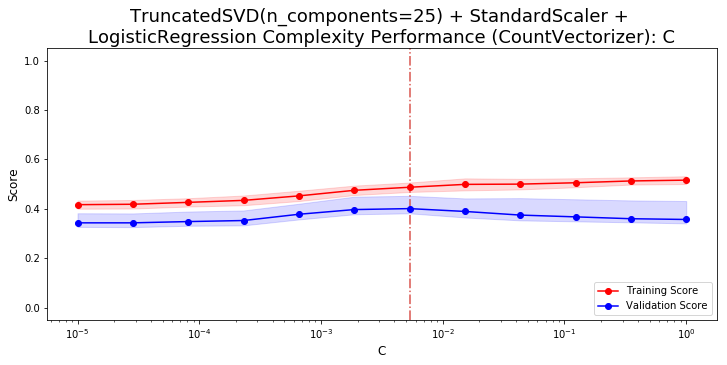

In [59]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count25)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nLogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.46631288 0.46933059 0.47385244 0.48297014 0.50595906 0.52691738
 0.54229116 0.55706458 0.56573664 0.57101488 0.57485775 0.57802261]
test_mean: [0.33478645 0.33750097 0.34233489 0.35744964 0.38251364 0.39366565
 0.38704182 0.37259375 0.34335614 0.33702385 0.31709842 0.31316857]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.39366564866993964
--------------------------------------------------------------------------------


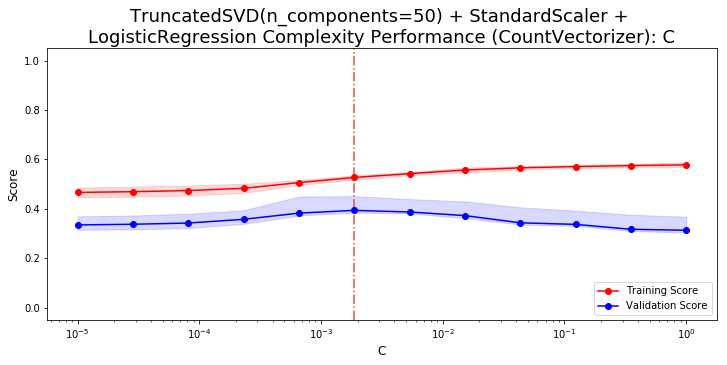

In [60]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count50)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=50) + StandardScaler + \nLogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.51268335 0.51441632 0.5198433  0.53762797 0.55556918 0.57313176
 0.58458687 0.59566811 0.60803442 0.62190598 0.62718267 0.63426953]
test_mean: [0.34117619 0.34177904 0.34389936 0.36235832 0.37718754 0.38356664
 0.36897126 0.3487497  0.32370036 0.32434452 0.3144196  0.30779923]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.3835666353766483
--------------------------------------------------------------------------------


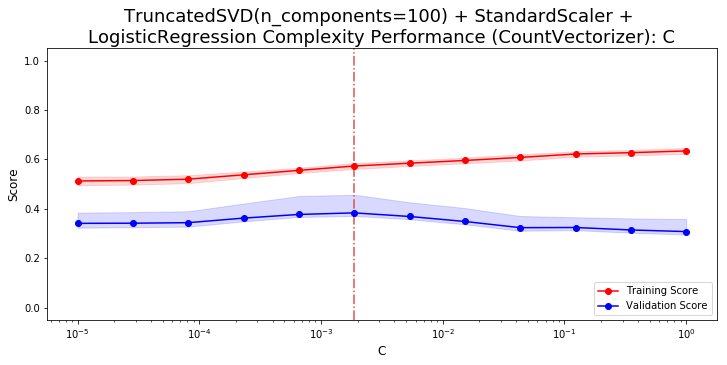

In [61]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count100)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=100) + StandardScaler + \nLogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.58814973 0.59003493 0.59787026 0.60970336 0.61904945 0.63096026
 0.6443753  0.66427653 0.68010496 0.69186371 0.70370618 0.71607047]
test_mean: [0.34482623 0.34391805 0.35061656 0.36178543 0.3807581  0.38468076
 0.37208229 0.36025791 0.35302193 0.33429489 0.3225211  0.32223408]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.38468075744208063
--------------------------------------------------------------------------------


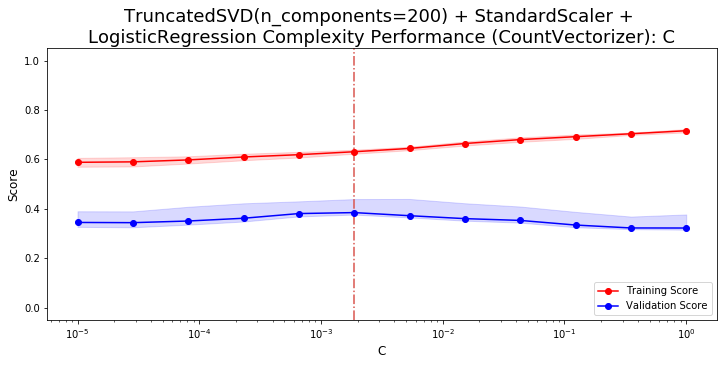

In [48]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count200)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=200) + StandardScaler + \nLogisticRegression Complexity Performance (CountVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.41294385 0.4188996  0.43617106 0.45516017 0.47271067 0.48446954
 0.49510122 0.51251408 0.5259404  0.5301625  0.53355483 0.53559149]
test_mean: [0.30770494 0.3086113  0.31162122 0.33363974 0.36053507 0.37139664
 0.36079161 0.34607892 0.35119003 0.34639961 0.33496077 0.33138381]
--------------------------------------------------------------------------------
C: 0.001873817422860383 achieves highest test score: 0.37139663582402055
--------------------------------------------------------------------------------


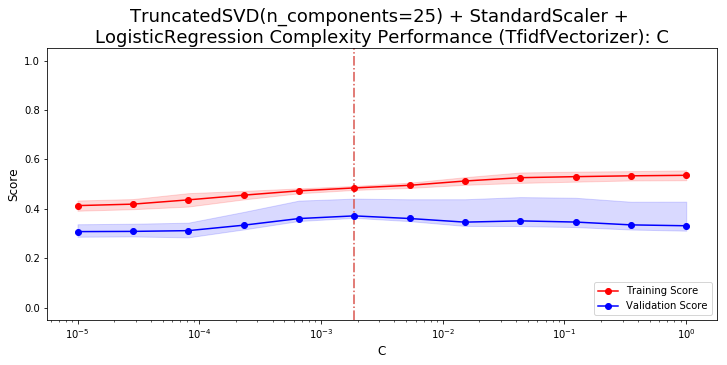

In [58]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf25)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nLogisticRegression Complexity Performance (TfidfVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.45463043 0.46662188 0.47883179 0.49104095 0.51499955 0.53490405
 0.55360109 0.56732348 0.57682362 0.58526784 0.590546   0.59325847]
test_mean: [0.29590769 0.3085944  0.31460512 0.3363256  0.37588973 0.36984967
 0.34362413 0.33311704 0.32860338 0.31987727 0.31085983 0.3084478 ]
--------------------------------------------------------------------------------
C: 0.0006579332246575682 achieves highest test score: 0.3758897262930139
--------------------------------------------------------------------------------


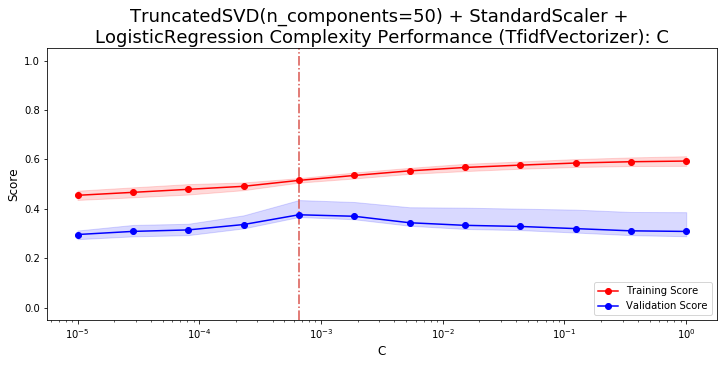

In [43]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf50)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=50) + StandardScaler + \nLogisticRegression Complexity Performance (TfidfVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.52565185 0.53666387 0.55053075 0.56831748 0.5903236  0.60487327
 0.61919784 0.6277144  0.63789198 0.6410546  0.64904448 0.65492605]
test_mean: [0.30584853 0.31004193 0.32668987 0.33181006 0.34612156 0.33612626
 0.32613208 0.32010673 0.31953641 0.31595312 0.30300457 0.29848495]
--------------------------------------------------------------------------------
C: 0.0006579332246575682 achieves highest test score: 0.3461215615707748
--------------------------------------------------------------------------------


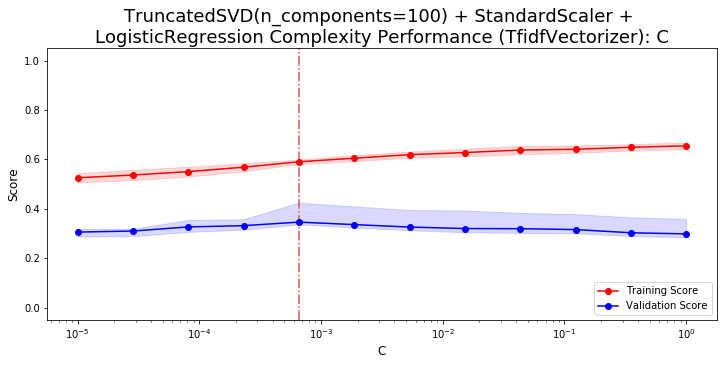

In [44]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf100)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=100) + StandardScaler + \nLogisticRegression Complexity Performance (TfidfVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

C: [1.00000000e-05 2.84803587e-05 8.11130831e-05 2.31012970e-04
 6.57933225e-04 1.87381742e-03 5.33669923e-03 1.51991108e-02
 4.32876128e-02 1.23284674e-01 3.51119173e-01 1.00000000e+00]
train_mean: [0.58226794 0.59614595 0.61136933 0.6290093  0.65183995 0.6634493
 0.67272049 0.67867463 0.68696533 0.69820192 0.70920865 0.71546616]
test_mean: [0.30763549 0.31673671 0.32671495 0.34239205 0.36837133 0.36476226
 0.33587853 0.31718572 0.31961248 0.30729946 0.30303894 0.29367595]
--------------------------------------------------------------------------------
C: 0.0006579332246575682 achieves highest test score: 0.3683713250008876
--------------------------------------------------------------------------------


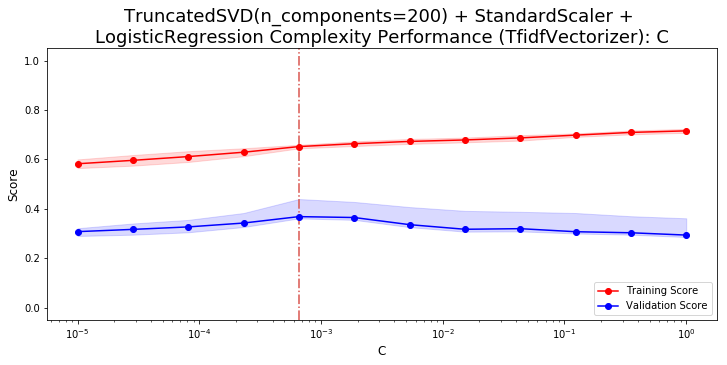

In [49]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf200)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
c_vals=np.logspace(-5,0,12)
train_scores, test_scores = validation_curve(LogisticRegression(n_jobs=-1,random_state=8), X, y, param_name = 'C', param_range = c_vals, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=200) + StandardScaler + \nLogisticRegression Complexity Performance (TfidfVectorizer): C'
plot_val_curve(train_scores,test_scores,'C', c_vals,title,logx=True)

**Conclusion for LogisticRegression**: 
1. CountVectorizer generally outperforms TfidfVectorizer.
2. Larger n_components values lead to increased training score but no increase in validation score, which means increased bias.
3. CountVectorizer with n_components=25 achieves the best performance.

<a id='Part2.4.2.2_link'></a>
### 2.4.2.2 Model evaluation

Here are some functions used in model evaluation.

In [50]:
def model_eval(clf, X, y):
    cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
    probas = cross_val_predict(clf, X, y, cv=cv, n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    preds=np.unique(y)[pred_indices]
    accuracy = accuracy_score(y, preds)
    logloss = log_loss(y, probas)
    print('accuracy score: {}'.format(accuracy))
    print('log_loss: {}'.format(logloss))
    output = pd.DataFrame(probas,columns=['Class{}'.format(i) for i in range(1,10)])
    output['pred']=preds
    return output

In [51]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()

In [52]:
def plot_acc_bar(cm,total_acc):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (20,8))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=18, fontweight='bold', rotation=45)
    plt.yticks(fontsize=16)
    plt.xlabel('Category', fontsize=18)
    plt.ylabel('Accuracy%', fontsize=18)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.25, v + 1, str(np.round(v,2))+'%', fontweight='bold', fontsize=18)
        ax.plot([-0.5, 8.5], [total_acc, total_acc], "k--", linewidth=2)
    ax.text(8.5, total_acc, 'Avg:\n'+str(total_acc)+'%', fontweight='bold', fontsize=18)

In [53]:
def plot_ROC_curve(acc_df):
    probas=np.array(acc_df.drop(['pred'],axis=1))

    fpr = dict()
    tpr = dict()
    auc_list = []
    label_to_class_dict = {i:l for i,l in enumerate(classes)}
    for i in np.arange(len(classes)):
        true_label_array = (y == i+1).astype(np.uint8)
        probs = probas[:,i]
        fpr[i], tpr[i], _ = roc_curve(true_label_array, probs)
        auc_value = auc(fpr[i], tpr[i])
        auc_list.append(auc_value)

    palette=sns.color_palette('hls',len(classes))
    for i in np.arange(len(classes)):
        plt.plot(fpr[i], tpr[i], color = palette[i], label='{} (area = {:.2f})'.format(classes[i], auc_list[i]))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

* Model: TruncatedSVD(n_components=25) + StandardScaler + LogisticRegression(C=0.005)

In [63]:
pl = Pipeline([('ss', StandardScaler(with_mean=False)),
               ('lr', LogisticRegression(C=0.005,n_jobs=-1,random_state=8))])
X=train_svd_count25
y=train_df.Class.values

In [64]:
output=model_eval(pl, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.3986731001206273
log_loss: 1.8545940757802533


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


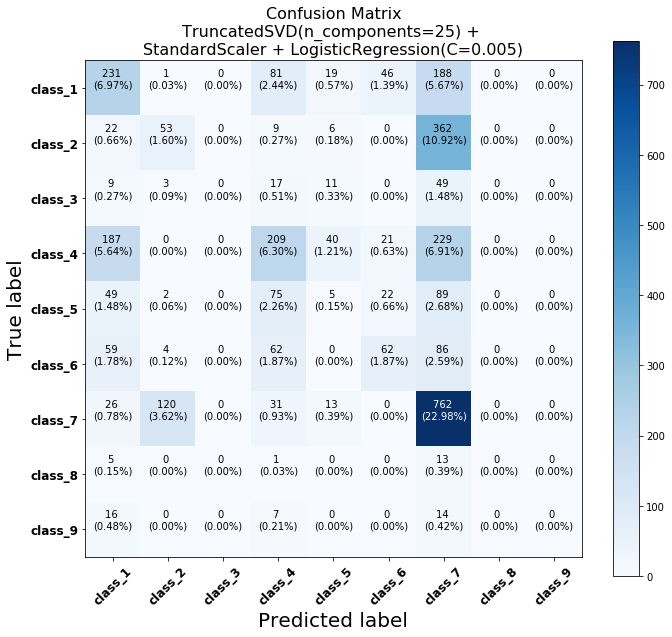

In [65]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nTruncatedSVD(n_components=25) + \nStandardScaler + LogisticRegression(C=0.005)', cmap=plt.cm.Blues)

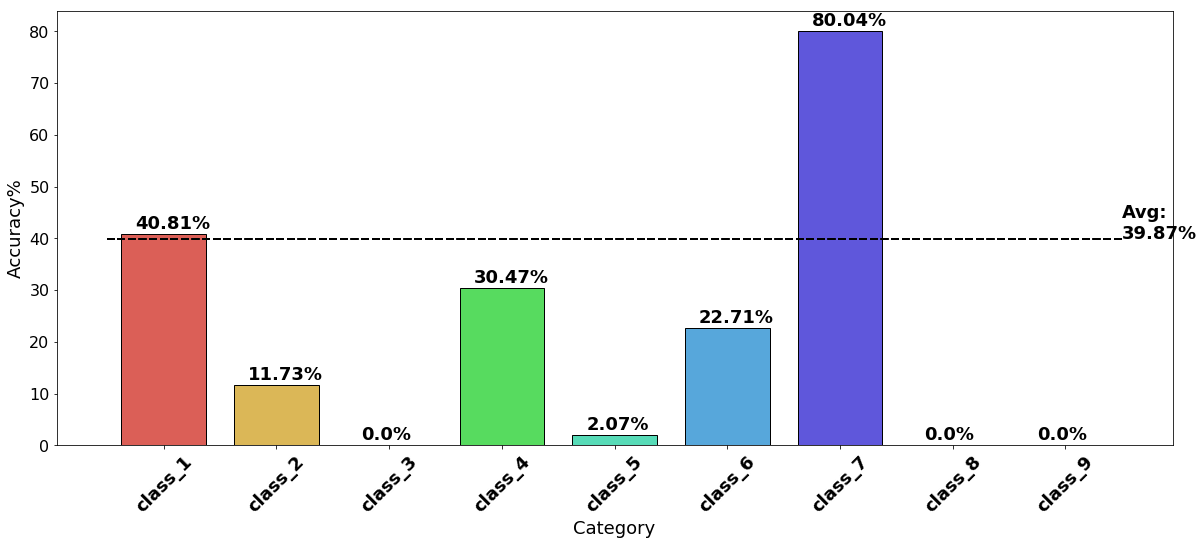

In [66]:
plot_acc_bar(cm,total_acc=39.87)

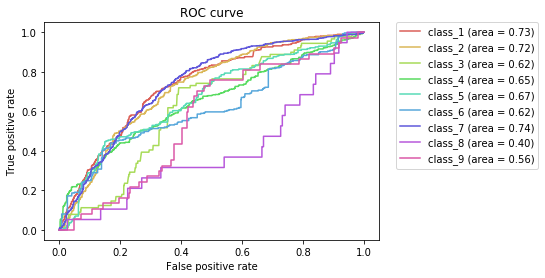

In [67]:
plot_ROC_curve(output)

<a id='Part2.4.3_link'></a>
### 2.4.3 RandomForestClassifier

<a id='Part2.4.3.1_link'></a>
### 2.4.3.1 validation_curve

* Model: TruncatedSVD + RandomForestClassifier

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.37220476 0.47466662 0.57350787 0.79704481 0.89754418 0.89679128
 0.89679128 0.89679128]
test_mean: [0.32574041 0.37701621 0.39852362 0.39488471 0.36235492 0.38589181
 0.38589181 0.38589181]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.39852362345165737
--------------------------------------------------------------------------------


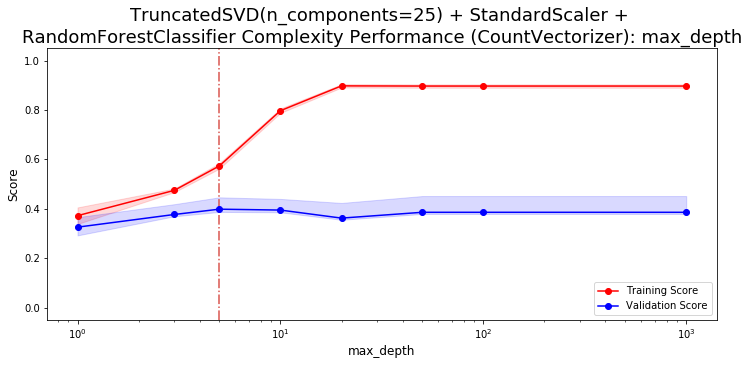

In [91]:
X=train_svd_count25
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD(n_components=25) + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.3653515  0.46848399 0.58412897 0.81808241 0.89732013 0.89664099
 0.89656546 0.89664099]
test_mean: [0.34796235 0.37460655 0.37581666 0.39547337 0.37715148 0.3821689
 0.3821689  0.3821689 ]
--------------------------------------------------------------------------------
max_depth: 10 achieves highest test score: 0.395473367350954
--------------------------------------------------------------------------------


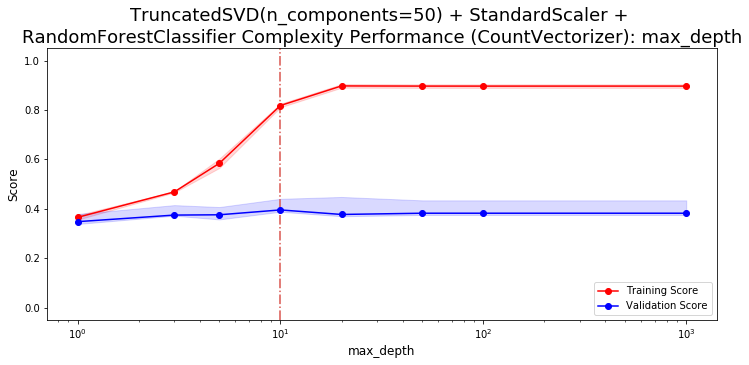

In [92]:
X=train_svd_count50
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD(n_components=50) + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.35389087 0.48892624 0.56545353 0.75557434 0.89520768 0.89746942
 0.89746942 0.89746942]
test_mean: [0.28328868 0.38227401 0.39926528 0.38602694 0.34713857 0.34587943
 0.34587943 0.34587943]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.3992652811689775
--------------------------------------------------------------------------------


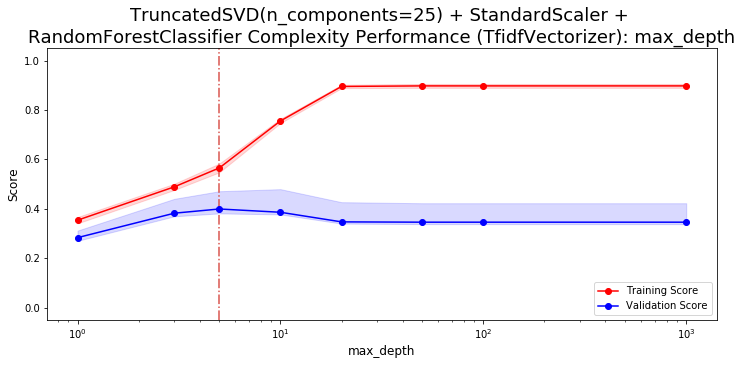

In [93]:
X=train_svd_tfidf25
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD(n_components=25) + StandardScaler + \nRandomForestClassifier Complexity Performance (TfidfVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.35786303 0.50189069 0.5723074  0.77201303 0.89430509 0.89626346
 0.89626346 0.89626346]
test_mean: [0.3053082  0.3876204  0.40881982 0.37114646 0.36152409 0.35126732
 0.35126732 0.35126732]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.4088198173738893
--------------------------------------------------------------------------------


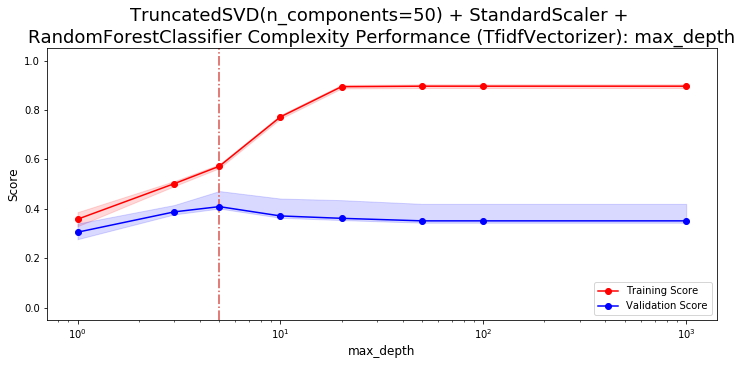

In [76]:
X=train_svd_tfidf50
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD(n_components=50) + StandardScaler + \nRandomForestClassifier Complexity Performance (TfidfVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

max_depth: [   1    3    5   10   20   50  100 1000]
train_mean: [0.3421328  0.49736705 0.58595598 0.78672138 0.89528401 0.89701682
 0.89701682 0.89701682]
test_mean: [0.31606333 0.37459683 0.38902673 0.38687354 0.3596841  0.37260102
 0.37260102 0.37260102]
--------------------------------------------------------------------------------
max_depth: 5 achieves highest test score: 0.3890267265442768
--------------------------------------------------------------------------------


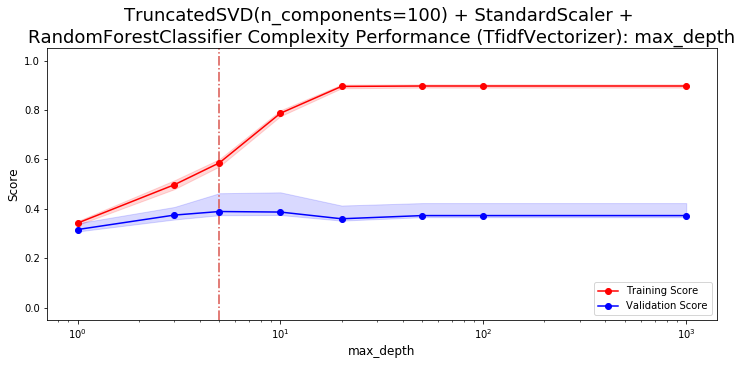

In [94]:
X=train_svd_tfidf100
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
max_depth=np.array([1,3,5,10,20,50,100,None])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'max_depth', param_range = max_depth, cv = cv, scoring = 'accuracy')
max_depth=np.array([1,3,5,10,20,50,100,1000])
title='TruncatedSVD(n_components=100) + StandardScaler + \nRandomForestClassifier Complexity Performance (TfidfVectorizer): max_depth'
plot_val_curve(train_scores,test_scores,'max_depth', max_depth,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89679128 0.79757541 0.68449306 0.52759882 0.43456028 0.39467653]
test_mean: [0.38589181 0.40819482 0.41480404 0.40425342 0.36818037 0.36338174]
--------------------------------------------------------------------------------
min_samples_leaf: 15 achieves highest test score: 0.41480404306603613
--------------------------------------------------------------------------------


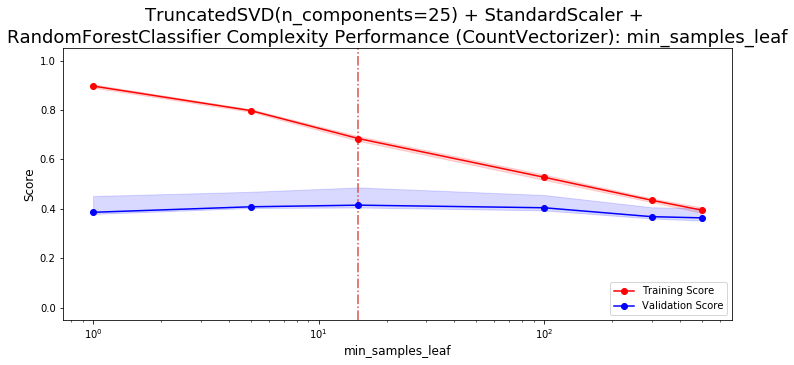

In [78]:
X=train_svd_count25
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89656546 0.81499395 0.7032612  0.52692154 0.41804621 0.38382323]
test_mean: [0.3821689  0.40365706 0.42837931 0.40392411 0.35678337 0.35609408]
--------------------------------------------------------------------------------
min_samples_leaf: 15 achieves highest test score: 0.4283793143936284
--------------------------------------------------------------------------------


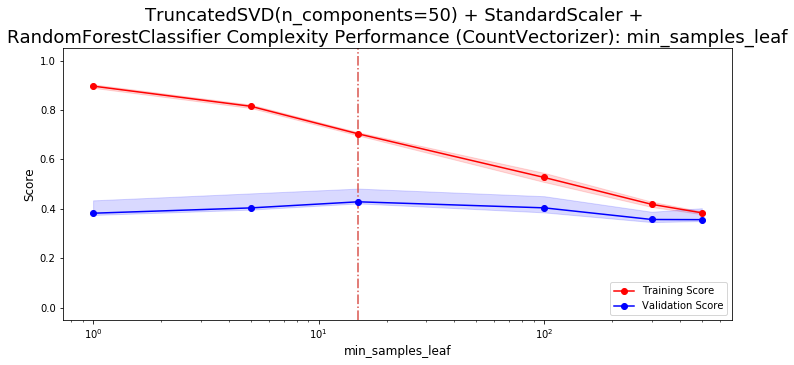

In [79]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count50)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=50) + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89845021 0.8220769  0.71562313 0.54448092 0.40922454 0.36670422]
test_mean: [0.37627345 0.41057637 0.42593158 0.36447049 0.37152857 0.34717744]
--------------------------------------------------------------------------------
min_samples_leaf: 15 achieves highest test score: 0.4259315835338164
--------------------------------------------------------------------------------


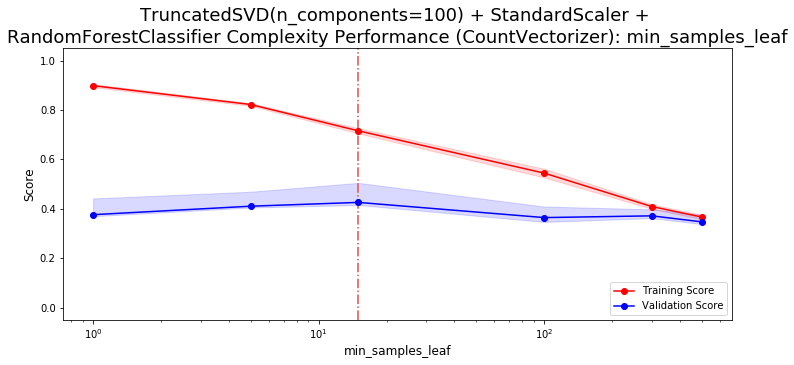

In [80]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_count100)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=100) + StandardScaler + \nRandomForestClassifier Complexity Performance (CountVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89739415 0.80224764 0.69149332 0.51719366 0.43782003 0.40289199]
test_mean: [0.34709339 0.35943982 0.37613786 0.4015421  0.36065396 0.3452421 ]
--------------------------------------------------------------------------------
min_samples_leaf: 100 achieves highest test score: 0.40154210434378046
--------------------------------------------------------------------------------


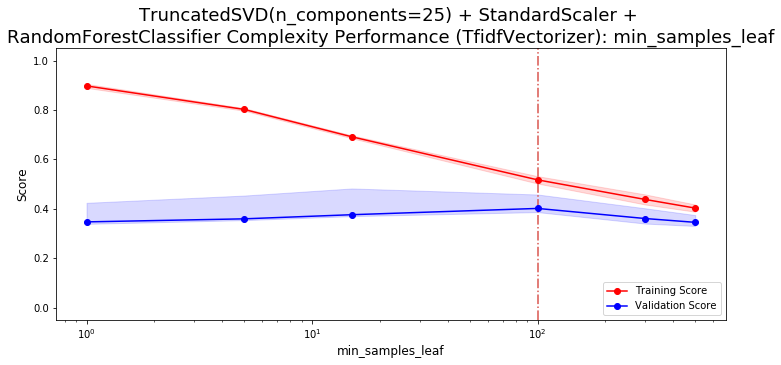

In [81]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf25)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nRandomForestClassifier Complexity Performance (TfidfVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

min_samples_leaf: [  1   5  15 100 300 500]
train_mean: [0.89626346 0.81370496 0.7080083  0.5381554  0.43594674 0.3676961 ]
test_mean: [0.35126732 0.39603418 0.3925918  0.38341244 0.33533456 0.3184751 ]
--------------------------------------------------------------------------------
min_samples_leaf: 5 achieves highest test score: 0.39603417908571303
--------------------------------------------------------------------------------


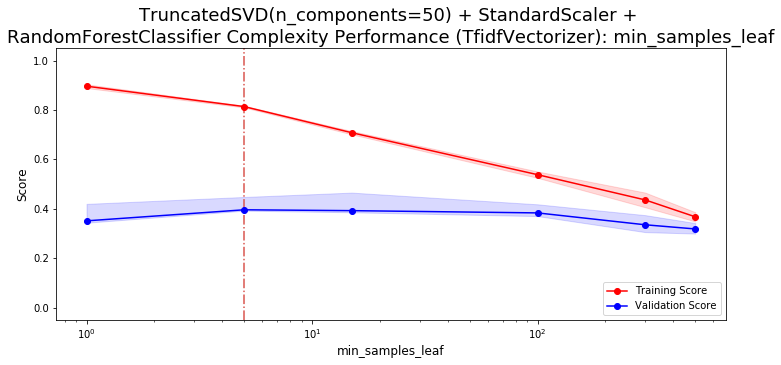

In [82]:
ss = StandardScaler(with_mean=False)
X=ss.fit_transform(train_svd_tfidf50)
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_samples_leaf=np.array([1,5,15,100,300,500])
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_samples_leaf', param_range = min_samples_leaf, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=50) + StandardScaler + \nRandomForestClassifier Complexity Performance (TfidfVectorizer): min_samples_leaf'
plot_val_curve(train_scores,test_scores,'min_samples_leaf', min_samples_leaf,title,logx=True)

**Conclusion for RandomForestClassifier**: 
1. The training performance is comparable between CountVectorizer and TfidfVectorizer.
2. Larger max_depth and smaller min_samples_leaf lead to overfitting.
3. CountVectorizer with TruncatedSVD(n_components=50) achieves the best performance with min_samples_leaf=15 for RandomForestClassifier.

<a id='Part2.4.3.2_link'></a>
### 2.4.3.2 Model evaluation

* Model: TruncatedSVD(n_components=50) + RandomForestClassifier(max_depth=10,min_samples_leaf=15)

In [95]:
clf=RandomForestClassifier(max_depth=10,min_samples_leaf=15,n_jobs=-1,random_state=8)
X=train_svd_count50
y=train_df.Class.values

In [96]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.42249698431845595
log_loss: 1.7446409116543342


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


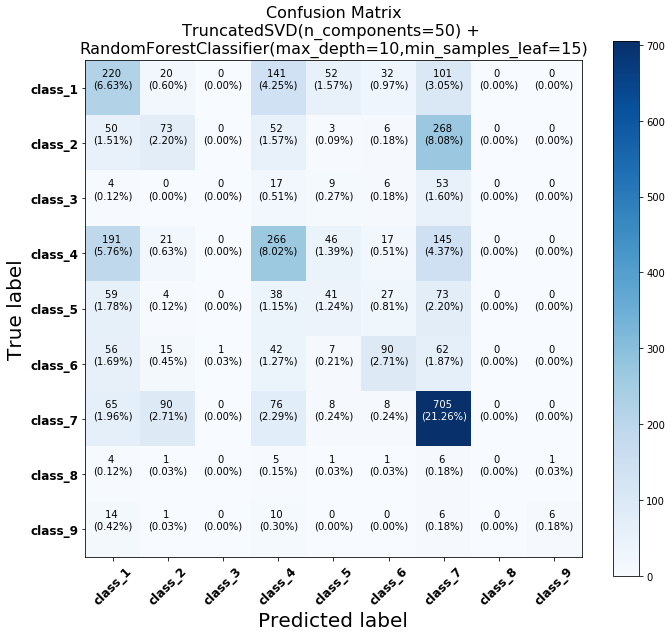

In [97]:
cm = confusion_matrix(train_df.Class.values, output.pred)
classes = ['class_{}'.format(i) for i in range(1,10)]
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix\nTruncatedSVD(n_components=50) + \nRandomForestClassifier(max_depth=10,min_samples_leaf=15)', cmap=plt.cm.Blues)

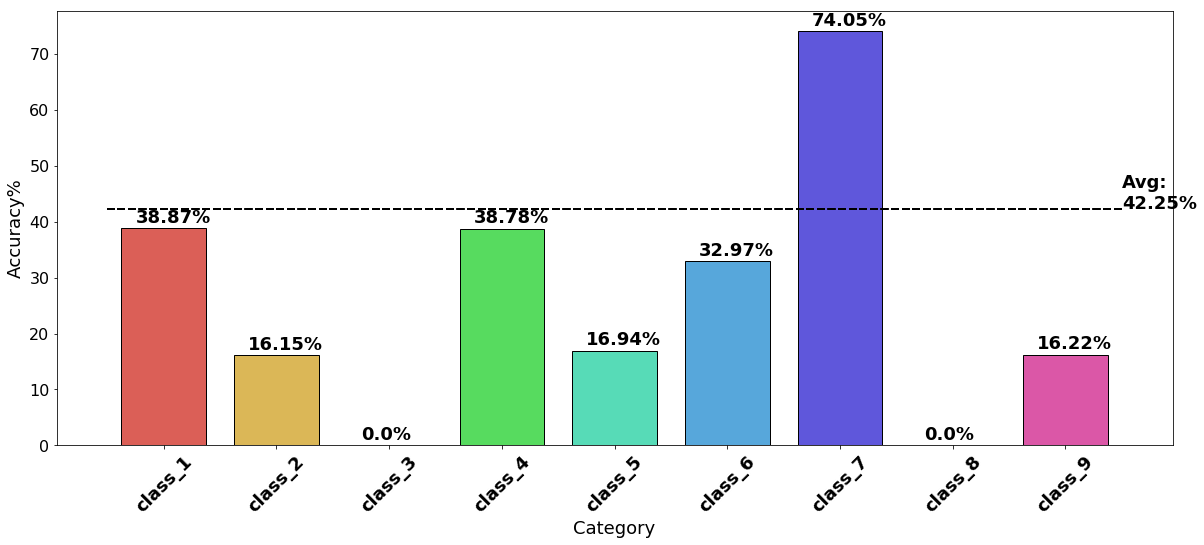

In [98]:
plot_acc_bar(cm,total_acc=42.25)

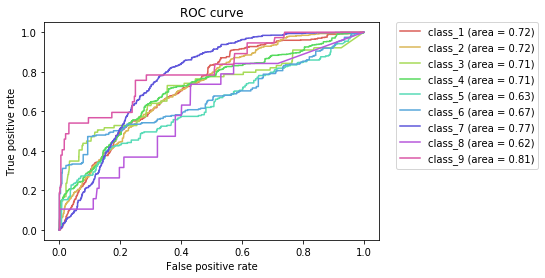

In [99]:
plot_ROC_curve(output)

<a id='Part2.4.4_link'></a>
### 2.4.4 XGBClassifier

https://xgboost.readthedocs.io/en/latest/parameter.html
<br>Important hyperparameters for **XGBClassifier**:
1. **eta** (learning_rate, default=0.3)
2. **gamma** (default=0): Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
3. **max_depth** (default=6): Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
4. **min_child_weight** (default=1): Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
5. **colsample_bytree** (default=1): The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

<a id='Part2.4.4.1_link'></a>
### 2.4.4.1 validation_curve

* Model: XGBClassifier

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.74337314 0.74646427 0.74781727 0.75286916 0.74676112]
test_mean: [0.42175297 0.40822285 0.39945318 0.40073925 0.39771167]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.421752968830513
--------------------------------------------------------------------------------


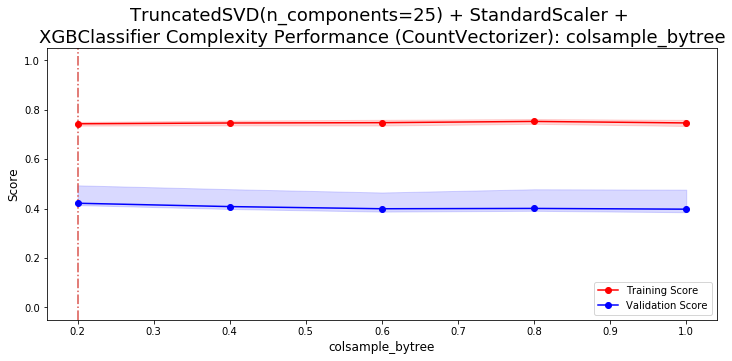

In [105]:
X=train_svd_count25
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nXGBClassifier Complexity Performance (CountVectorizer): colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

colsample_bytree: [0.2 0.4 0.6 0.8 1. ]
train_mean: [0.77978307 0.78257211 0.78875315 0.78882606 0.78837346]
test_mean: [0.42531591 0.42418202 0.42117586 0.41785438 0.4127447 ]
--------------------------------------------------------------------------------
colsample_bytree: 0.2 achieves highest test score: 0.4253159124850888
--------------------------------------------------------------------------------


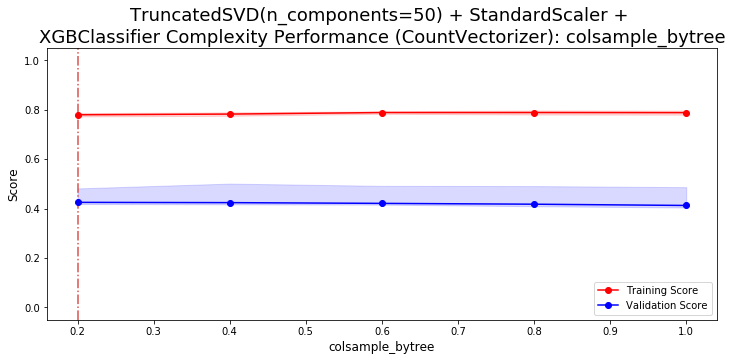

In [106]:
X=train_svd_count50
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
colsample_bytree=np.array([0.2, 0.4, 0.6, 0.8, 1.0])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'colsample_bytree', param_range = colsample_bytree, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=50) + StandardScaler + \nXGBClassifier Complexity Performance (CountVectorizer): colsample_bytree'
plot_val_curve(train_scores,test_scores,'colsample_bytree', colsample_bytree,title,logx=False)

min_child_weight: [ 1  3  5  8 10 20]
train_mean: [0.74676112 0.74329027 0.74027751 0.73386901 0.73273756 0.71751021]
test_mean: [0.39771167 0.39766904 0.39891656 0.39707978 0.4040195  0.40850339]
--------------------------------------------------------------------------------
min_child_weight: 20 achieves highest test score: 0.40850339258605955
--------------------------------------------------------------------------------


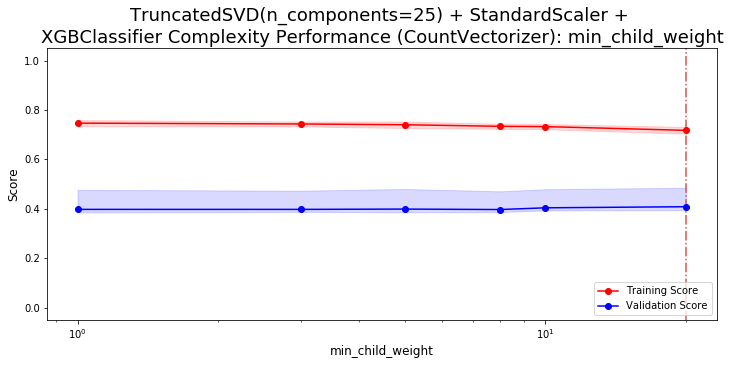

In [107]:
X=train_svd_count25
y=train_df.Class.values
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=8)
min_child_weight=np.array([1, 3, 5, 8, 10, 20])
train_scores, test_scores = validation_curve(XGBClassifier(n_jobs=-1,random_state=8), X, y, param_name = 'min_child_weight', param_range = min_child_weight, cv = cv, scoring = 'accuracy')
title='TruncatedSVD(n_components=25) + StandardScaler + \nXGBClassifier Complexity Performance (CountVectorizer): min_child_weight'
plot_val_curve(train_scores,test_scores,'min_child_weight', min_child_weight,title,logx=True)

<a id='Part2.4.4.2_link'></a>
### 2.4.4.2 Model evaluation

* Model: TruncatedSVD(n_components=50) + XGBClassifier(colsample_bytree=0.2)

In [108]:
clf=XGBClassifier(colsample_bytree=0.2)
X=train_svd_count50
y=train_df.Class.values

In [109]:
output=model_eval(clf, X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


accuracy score: 0.4324487334137515
log_loss: 1.6058410665782032


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.2s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


## Conclusion for LSA:

1. The overall training performance for LSA method is not better than BOW using `CountVectorizer` and `TfidfVectorizer`, with overall validation accuracy around 0.40.
2. Larger n_components value in **TruncatedSVD** leads to increased bias and overfitting. Generally n_components=25 or 50 achieves better performance.